## Importing data and cleaning

In [19]:
import pandas as pd
import numpy as np

# some dependence/correlation tests
from scipy.stats import f_oneway, kruskal, chi2_contingency 

# Clustering algorithms
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes

# Visualization
from matplotlib import pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load data
for el in ['customers', 'parcels', 'apms']:
    globals()[el] = pd.read_csv(el + '.csv')
    n,m = globals()[el].shape
    print('{} loaded with {} records and {} columns'.format(el, n, m))
    if globals()[el].isna().any().sum()!=0:
        print('There is missing data in {}'.format(el))


customers loaded with 91447 records and 3 columns
parcels loaded with 101597 records and 6 columns
apms loaded with 23546 records and 3 columns
There is missing data in apms


### Cleaning the parcels data set

The following operations have been performed:
* The 'data_nadania' field is stored as an integer, so I change it into a pandas Timestamp
* Since we are taking L12M as basis I will leave only rows that go 12 months back compared to the last shipment
* Check id 'id_paczka' is unique. It should be.
* I check if ther are 'kanał' and 'sposob_dostawy' have no strange values. Thankfully both look good.
* Merge with apms to check if every parcel shipment corresponds to some 'id_paczkomat' in apms. This turns out to be true.
* Merge with customers to check if every parcel shipment corresponds to some 'id_klient' in customers. This also turns out to be true


In [3]:
# The 'data_nadania' field is stored as an integer, so I change it into a pandas Timestamp
parcels['data_nadania']  = \
    pd.to_datetime(parcels['data_nadania'].apply(lambda x: str(x)[0:4]+'-'+str(x)[4:6]+'-'+str(x)[6:8]))


# Since we are taking L12M as basis I will leave only rows that go 12 months back compared to the last shipment
parcels = parcels[parcels['data_nadania'] >= parcels['data_nadania'].max() - pd.DateOffset(years=1)]

# Check id 'id_paczka' is unique. It should be.
print('Id_paczka is unique: ', parcels['id_paczka'].nunique()==parcels.shape[0])


# I check if ther are 'kanał' and 'sposob_dostawy' have no strange values. Thankfully both look good.
print('Kanał unique values: ', parcels['kanał'].unique())
print('Sposob_dostawy unique values: ', parcels['sposob_dostawy'].unique())

# Merge with apms to check if every parcel shipment corresponds to some 'id_paczkomat' in apms. This turns out to be true.
print('Every parcel is associated with some id_paczkomtat: ', parcels.merge(apms, how='inner', on=['id_paczkomat']).shape[0] == parcels.shape[0])


# Merge with customers to check if every parcel shipment corresponds to some 'id_klient' in customers. This also turns out to be true
print('Every parcel is associated with some id_klient: ',parcels.merge(customers, how='inner', on=['id_klient']).shape[0] == parcels.shape[0])


Id_paczka is unique:  True
Kanał unique values:  ['app' 'www']
Sposob_dostawy unique values:  ['APM' 'COURIER']
Every parcel is associated with some id_paczkomtat:  True
Every parcel is associated with some id_klient:  True


### Cleaning the customers data set

The following operations have been performed:
* First I wat to be sure that each customer id is appears only once in the data set. 
* I also look at the unique values of 'kategoria' field to see if there aren't any missing values.
* Finally I observe that 'zgoda_marketingowa' takes on the value 'True' for each and every customer, which makes it obsolete (it carries no information) and it will not be used in the analysis.


In [4]:
# First I wat to be sure that each customer id is appears only once in the data set. 
print('Id_klient is unique: ', customers['id_klient'].nunique() == customers.shape[0])

# I also look at the unique values of 'kategoria' field to see if there aren't any missing values.
print('Unique values in kategoria: ', customers['kategoria'].unique())

# Finally I observe that 'zgoda_marketingowa' takes on the value 'True' for each and every customer, which makes it obsolete (it carries no observation) and it will not be used in the analysis.
print('Unique values in zgoda_marketingowa: ',customers['zgoda_marketingowa'].unique())
customers = customers[['id_klient', 'kategoria']]


Id_klient is unique:  True
Unique values in kategoria:  ['office' 'pets' 'fashion']
Unique values in zgoda_marketingowa:  [ True]


### Cleaning the apms data set

The following operation have been performed:
* Frist I make sure that 'id_paczkomat' contains unuque values. Fortunataly this is the case.
* In this data set we do have missing values. I filter them out using mainly common sense, and then I check that the 'id_paczkomat' for rows with missing values does not correspond to any parcels. This allows me to simply delete the rows with missing values as they will play no role in the analysis, as there is no way to link them to a client, as there is no parcel to link by.
* The next small problem with this data set is that one 'miejscowosc' may be assigned to different 'klasa_miejscowosci'. In some rare cases, this could be the result of two  geographically different places sharing the same name, but my observation is that these are bugged data. Hence, I will assign the most common value in 'klasa_miejscowosci' for each 'miejscowosc'
* Finally, I will drop the field 'miejscowosc' as the name itself poses little interest. I will only use 'klasa_miejscowosci' i the analysis.


In [5]:
# Frist I make sure that 'id_paczkomat' contains unuque values. Fortunataly this is the case.
print('Id_paczkomat is unique: ', apms['id_paczkomat'].nunique() == apms.shape[0])

'''
In this data set we do have missing values. I filter them out using mainly common sense, and then I check that 
the 'id_paczkomat' for rows with missing values does not correspond to any parcels. This allows me to simply delete the rows with missing values as they will 
play no role in the analysis, as there is no way to link them to a client, as there is no parcel to link by.
'''
L = apms[(apms['klasa_miejscowosci'].isna()) # NaN values
     | (apms['miejscowosc'].apply(lambda x: len(x)<=2)) # length of a name of town or village will be greater than 2 
     | (apms['id_paczkomat'].apply(lambda x: x.upper()!=x)) # check if 'id_paczkomat' does have some strange lower case values 
     | (apms['miejscowosc'].apply(lambda x: x.upper()=='TEST'))# TEST as name of a place is obviously suspicsious
     | (apms['miejscowosc'].apply(lambda x: x[0].lower() == 'x'))
        ] 

print('{} Missing values: '.format(L.shape[0]))
display(L)

# Here I checj that the APMS with missing values do not appear in parcels data set
print('Missing values are not associated with any parcels: ',parcels[parcels['id_paczkomat'].apply(lambda x: x in L['id_paczkomat'].to_list())].shape[0] == 0)

# Delete the obsolete rows:
apms = apms[~apms.index.isin(L.index)]


'''
The next small problem with this data set is that the same 'miejscowosc' may be assigned to 
different 'klasa_miejscowosci'. In some rare cases, this could be the result of two  
geographically different places sharing the same name, but my observation is that these are bugged data. 
Hence, I will assign the most common value in 'klasa_miejscowosci' for each 'miejscowosc'
'''
print('Unique values in klasa_miejscowosci:\n',apms['klasa_miejscowosci'].unique()) # just to check for potential na's

# Get the most common 'klasa_miejscowosci' for 'miejscowosc' with multiple 'klasa_miejscowosci':
klasa_m = apms.groupby('miejscowosc')['klasa_miejscowosci'].agg(pd.Series.mode)
klasa_m = klasa_m.apply(lambda x: str(x[0]) if type(x)!=str else x).to_frame().reset_index()


# Merge, so that now each 'miejscowosc' will correspond to exactly one 'klasa_miejscowosci'
apms = apms[['id_paczkomat', 'miejscowosc']].merge(klasa_m, how = 'left', on=['miejscowosc'])
apms.reset_index(inplace=True, drop=True)


# Finally, I will drop the field 'miejscowosc' as the name itself poses little interest. I will only use 'klasa_miejscowosci' i the analysis.
apms = apms[['id_paczkomat', 'klasa_miejscowosci']]


Id_paczkomat is unique:  True
36 Missing values: 


,id_paczkomat,miejscowosc,klasa_miejscowosci
626,BIA22A,X,miasto 200 - 500 tys. mieszkańców
2412,CPK01G,CHALUPKI,NaN
2473,CSS01N,TEST,NaN
2874,DEB108,TEST,miasto 20 - 50 tys. mieszkańców
5730,JRC04A,X,miasto 20 - 50 tys. mieszkańców
5826,JUR02M,TEST,NaN
7779,KRA405,XXXX,miasto powyżej 500 tys. mieszkańców
7991,KRO143,TEST,miasto 20 - 50 tys. mieszkańców
8114,KSO01A,XXX,miasto do 20 tys. mieszkańców
8481,KZE01N,KALWARIA ZEBRZYDOWSKA,NaN


Missing values are not associated with any parcels:  True
Unique values in klasa_miejscowosci:
 ['wieś' 'miasto do 20 tys. mieszkańców' 'miasto 20 - 50 tys. mieszkańców'
 'miasto powyżej 500 tys. mieszkańców' 'miasto 100 - 200 tys. mieszkańców'
 'miasto 50 - 100 tys. mieszkańców' 'miasto 200 - 500 tys. mieszkańców']


## Merging and building features for cluster analysis

Having cleaned data sets 'customers', 'parcels' and 'apms' I now merge them into  one data set on which I  actually perform cluster analysis.

The intention is two cluster clients. Affter merging one customer will appear as many times as many parcels they have sent. In order to keep one record for one customer I will aggregate data building the following features:

* number of parceles sent in L12M per customer
* time elapsed in days from sending last parcel. If no parcel was sent, I arbitrally set to 1000 days
* field 'kategoria' - this field is unique for each customer and I leave it as a categorical variable.
* field 'kanał' - split into fields 'app' and 'www' each indicating the proportion of parcels sent by app or www per customer
* field 'sposob dostawy' - split into fields 'apm' and 'courier' each indicating the proportion of parcels sent by apm or courier by a customer
* field 'klasa_miejscowosci'  - I will transform this field into a numerical one sum and divide by number of parcels to obtain the average size of town to which parcels were sent. 


In [6]:
# perform the merge
df = customers.merge(parcels, how = 'left', on =['id_klient']).merge(apms, how = 'left', on=['id_paczkomat'])


#num parcecels
df['num_parcels'] = df['id_paczkomat'].groupby(df['id_klient']).transform('count')


# how many days ago was there a parcel
df['last_parcel_days'] = df['data_nadania'].groupby(df['id_klient']).transform('max')
df['last_parcel_days'] = parcels['data_nadania'].max() - df['last_parcel_days']

# Recoding 'klasa_miejscowosci' into a numeric mean town size of parcels sent
D = {'miasto do 20 tys. mieszkańców':10, 
     'miasto powyżej 500 tys. mieszkańców':500, 
     'miasto 50 - 100 tys. mieszkańców': 75,
     'wieś': 5,
     'miasto 200 - 500 tys. mieszkańców': 350,
      'miasto 100 - 200 tys. mieszkańców':150,
      'miasto 20 - 50 tys. mieszkańców':35
    }
df['klasa_miejscowosci'] = (
    df['klasa_miejscowosci']
     .apply(lambda x: D[x] if x in D.keys() else 0)
     .groupby(df['id_klient'])
     .transform('sum'))/df['num_parcels']
df['klasa_miejscowosci'] = df['klasa_miejscowosci'].fillna(0)

# Split 'kanał' into two numeric fields: 'www' and 'app'. If customer has parcels they will add up to one
df['www'] = (df['kanał'].apply(lambda x: 1 if x=='www' else 0).groupby(df['id_klient']).transform('sum'))/df['num_parcels']
df['www'] = df['www'].fillna(0)

df['app'] = (df['kanał'].apply(lambda x: 1 if x=='app' else 0).groupby(df['id_klient']).transform('sum'))/df['num_parcels']
df['app'] = df['app'].fillna(0)


# Split 'sposob_dostawy' into two numeric fields: 'apm' and 'courier'. If customer has parcels they will add up to one
df['apm'] = (df['sposob_dostawy'].apply(lambda x: 1 if x=='APM' else 0).groupby(df['id_klient']).transform('sum'))/df['num_parcels']
df['apm'] = df['apm'].fillna(0)


df['courier'] = (df['sposob_dostawy'].apply(lambda x: 1 if x=='COURIER' else 0).groupby(df['id_klient']).transform('sum'))/df['num_parcels']
df['courier'] = df['courier'].fillna(0)


# leav only one row per 'id_klient' creating the final date set for segmentation:
df.drop_duplicates(subset=['id_klient'], ignore_index=True, inplace=True)
df = df[['id_klient', 'num_parcels', 'last_parcel_days', 'www', 'app', 'apm', 'courier',  'klasa_miejscowosci','kategoria']]


# if client never sent a parcel, I need to input some value for last_parcel_days field. I will arbitrally set it to 1000
# also I change the timedelta type into integers
df['last_parcel_days'] = df['last_parcel_days'].dt.days.astype('float').fillna(1000)

df.head()

,id_klient,num_parcels,last_parcel_days,www,app,apm,courier,klasa_miejscowosci,kategoria
0,EZNN08756728558789,0,1000.0,0.0,0.0,0.0,0.0,0.0,office
1,PQDQ50319580649846,0,1000.0,0.0,0.0,0.0,0.0,0.0,pets
2,ILIW22855294396545,0,1000.0,0.0,0.0,0.0,0.0,0.0,pets
3,CHKM11557944525210,0,1000.0,0.0,0.0,0.0,0.0,0.0,pets
4,AAYP94510865279436,0,1000.0,0.0,0.0,0.0,0.0,0.0,office


The last step before feeding the data into a clustering algorithm is to standarize and weights (based on common sense judgement) and change into a numpy array.

In [7]:
# standarize before clustering:
X = df.copy()
# I want to add some weights, becuase otherwise the clusters would be heavilty determined by 'kanał' and 'sposob_dostawy'
weights = [1.8,1.6,1,1,1,1,1.15] 


for j, col in enumerate(['num_parcels', 'last_parcel_days', 'www', 'app', 'apm', 'courier', 'klasa_miejscowosci']):
    X[col] = weights[j]*(X[col]-X[col].mean())/X[col].std()
    #X[col] = weights[j]*(X[col].max()-X[col])/(X[col].max() - X[col].min())

X = X.iloc[:,1:].to_numpy()


## Clustering

I persue two approaches. First I use the k-prototypes algorithm which is recomended for data sets with both numerical and categorical variables ('kategoria' is a categorical variable). 

Second, I run a regular kMeans algorithm using the data set without 'kategoria'. This may seem like dropping some important imformation, but two justify it I show that 'kategoria' seems independet from the number of parcels.

I choose the number of cluster using the "elbow method", i.e. by looking at scree plots


In [17]:
cost = []
# CAUTION: this takes a long time to execute
for num_clusters in range(1, 8):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = num_clusters, init = 'Huang',)
    kprototype.fit_predict(X, categorical = [7])
    cost.append(kprototype.cost_)

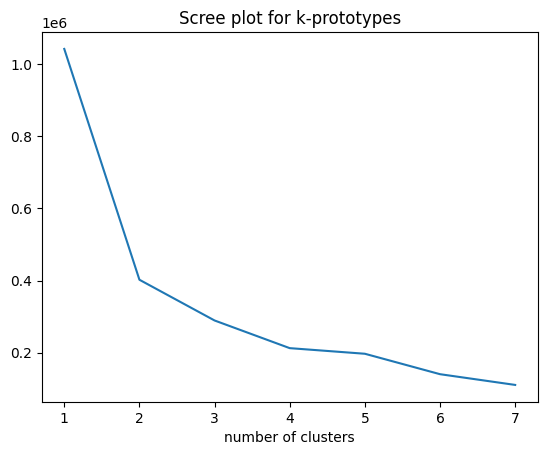

In [16]:
plt.plot(range(1,8), cost)
plt.title('Scree plot for k-prototypes')
plt.xlabel('number of clusters')
plt.xticks(range(1,8))
plt.show()


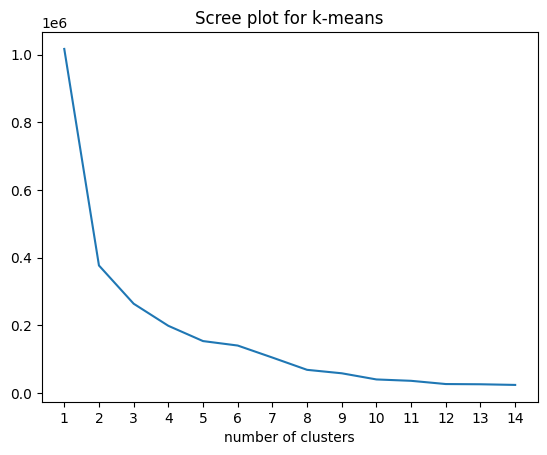

In [24]:
cost_kmeans = []
for num_clusters in range(1, 15):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(X[:,: -1])
    cost_kmeans.append(kmeans.inertia_)

plt.plot(range(1,15), cost_kmeans)
plt.title('Scree plot for k-means')
plt.xlabel('number of clusters')
plt.xticks(range(1,15))
plt.show()

Both algorithms suggest around 4 clusters. Below I add a degressibe justification of using k-means without the field 'kategoria'.



### What is wrong with the categorical variable 'kategoria'?

Tests below (note the large p-values) show that 'kategoria' varibale is independent from every other variable. In other words, the conditional distribution of clients favoring 'pets', 'office' or 'fashion' will be the same if we condition on any other vairables. Therefore 'kategoria' will not pull observations into any particular cluster and dropping this variable will have almost no impact on the resulting clusters.



In [25]:
tmp = customers.merge(parcels, how = 'left', on =['id_klient']).merge(apms, how = 'left', on=['id_paczkomat']).dropna()


# Use kruskal non-parametric test for num_parcels which is oridinal by nature
print(
kruskal(df[df['kategoria']=='pets']['num_parcels'], 
        df[df['kategoria']=='office']['num_parcels'], 
        df[df['kategoria']=='fashion']['num_parcels'])
)

# one way anova for last_parcel_days
print('\n',
f_oneway(df[df['kategoria']=='pets']['last_parcel_days'], 
        df[df['kategoria']=='office']['last_parcel_days'], 
        df[df['kategoria']=='fashion']['last_parcel_days'])
)

#chi-square contingency tables for comparing two categorical variables:
ct_table = pd.crosstab(tmp['kategoria'], tmp['kanał'])
display(ct_table)
print('\n', chi2_contingency(ct_table))


ct_table = pd.crosstab(tmp['kategoria'], tmp['sposob_dostawy'])
display(ct_table)
print('\n',chi2_contingency(ct_table))


ct_table = pd.crosstab(tmp['kategoria'], tmp['klasa_miejscowosci'])
display(ct_table)
print('\n', chi2_contingency(ct_table))



KruskalResult(statistic=0.9742848609867597, pvalue=0.6143795203343428)

 F_onewayResult(statistic=0.3539158757465163, pvalue=0.701934976000566)


kanał,app,www
kategoria,,
fashion,7267,2833
office,5955,2335
pets,16062,6187



 Chi2ContingencyResult(statistic=0.46386229554092656, pvalue=0.7930007212947509, dof=2, expected_freq=array([[ 7277.94483132,  2822.05516868],
       [ 5973.67947046,  2316.32052954],
       [16032.37569822,  6216.62430178]]))


sposob_dostawy,APM,COURIER
kategoria,,
fashion,6540,3560
office,5285,3005
pets,14330,7919



 Chi2ContingencyResult(statistic=2.038181301934806, pvalue=0.3609229959690882, dof=2, expected_freq=array([[ 6500.29528286,  3599.70471714],
       [ 5335.39088068,  2954.60911932],
       [14319.31383646,  7929.68616354]]))


klasa_miejscowosci,miasto 100 - 200 tys. mieszkańców,miasto 20 - 50 tys. mieszkańców,miasto 200 - 500 tys. mieszkańców,miasto 50 - 100 tys. mieszkańców,miasto do 20 tys. mieszkańców,miasto powyżej 500 tys. mieszkańców,wieś
kategoria,,,,,,,
fashion,910,1219,1128,796,1648,2186,2213
office,715,1044,948,656,1366,1825,1736
pets,1934,2849,2457,1798,3572,4935,4704



 Chi2ContingencyResult(statistic=9.48471795161987, pvalue=0.661065771201415, dof=12, expected_freq=array([[ 884.51733556, 1270.48401782, 1126.58529984,  807.72164669,
        1636.81685081, 2223.34703118, 2150.52781811],
       [ 726.00482295, 1042.80321858,  924.69229066,  662.97152981,
        1343.48630626, 1824.90563252, 1765.13619922],
       [1948.47784148, 2798.7127636 , 2481.72240951, 1779.30682349,
        3605.69684293, 4897.7473363 , 4737.33598268]]))


## Cluster interpretations

In [38]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang')
kprototype.fit_predict(X, categorical = [7])

C = pd.DataFrame(kprototype.labels_, columns=['cluster'])
res = pd.concat([C, df] ,axis=1)

res.groupby('cluster').agg(
    num_parcels_mean=('num_parcels', 'mean'), 
    last_parcel_days_mean=('last_parcel_days', 'mean'),
    www_mean = ('www', 'mean'),
    app_mean = ('app', 'mean'),
    apm_mean = ('apm', 'mean'),
    courier_mean = ('courier', 'mean'),
    klasa_miejscowosci_med = ('klasa_miejscowosci', 'median'),
    kategoria_mode = ('kategoria', pd.Series.mode),
    cluster_size = ('id_klient', 'count')
    )


,num_parcels_mean,last_parcel_days_mean,www_mean,app_mean,apm_mean,courier_mean,klasa_miejscowosci_med,kategoria_mode,cluster_size
cluster,,,,,,,,,
0,1.175215,162.891092,0.001957,0.998043,0.987239,0.012761,10.0,pets,11854
1,1.020662,173.307957,0.324419,0.675581,0.000228,0.999772,35.0,pets,13648
2,1.062531,171.087394,0.524766,0.475234,0.995047,0.004953,350.0,pets,12026
3,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,0.0,pets,53919


In [27]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(X[:,: -1])

C = pd.DataFrame(kmeans.labels_, columns=['cluster'])

res1 = pd.concat([C, df],  axis=1)
res1.groupby('cluster').agg(
    num_parcels_mean=('num_parcels', 'mean'), 
    last_parcel_days_mean=('last_parcel_days', 'mean'),
    www_mean = ('www', 'mean'),
    app_mean = ('app', 'mean'),
    apm_mean = ('apm', 'mean'),
    courier_mean = ('courier', 'mean'),
    klasa_miejscowosci_med = ('klasa_miejscowosci', 'median'),
    kategoria_mode = ('kategoria', pd.Series.mode),
    cluster_size = ('id_klient', 'count')
    )

,num_parcels_mean,last_parcel_days_mean,www_mean,app_mean,apm_mean,courier_mean,klasa_miejscowosci_med,kategoria_mode,cluster_size
cluster,,,,,,,,,
0,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,0.0,pets,53919
1,1.130383,163.940911,0.000767,0.999233,0.990733,0.009267,75.0,pets,17533
2,1.022847,172.103926,0.238081,0.761919,0.000887,0.999113,35.0,pets,12124
3,1.069623,176.947148,0.998825,0.001175,0.799265,0.200735,150.0,pets,7871


Both clustering reuslts are in a way similar, but the k-prototypes seems to be less focused on forming clsuters around application vs website and sending via APM vs courier and easier to interpretable. Below I present some plots that depict differences between the four clusters returned by k-prototypes.

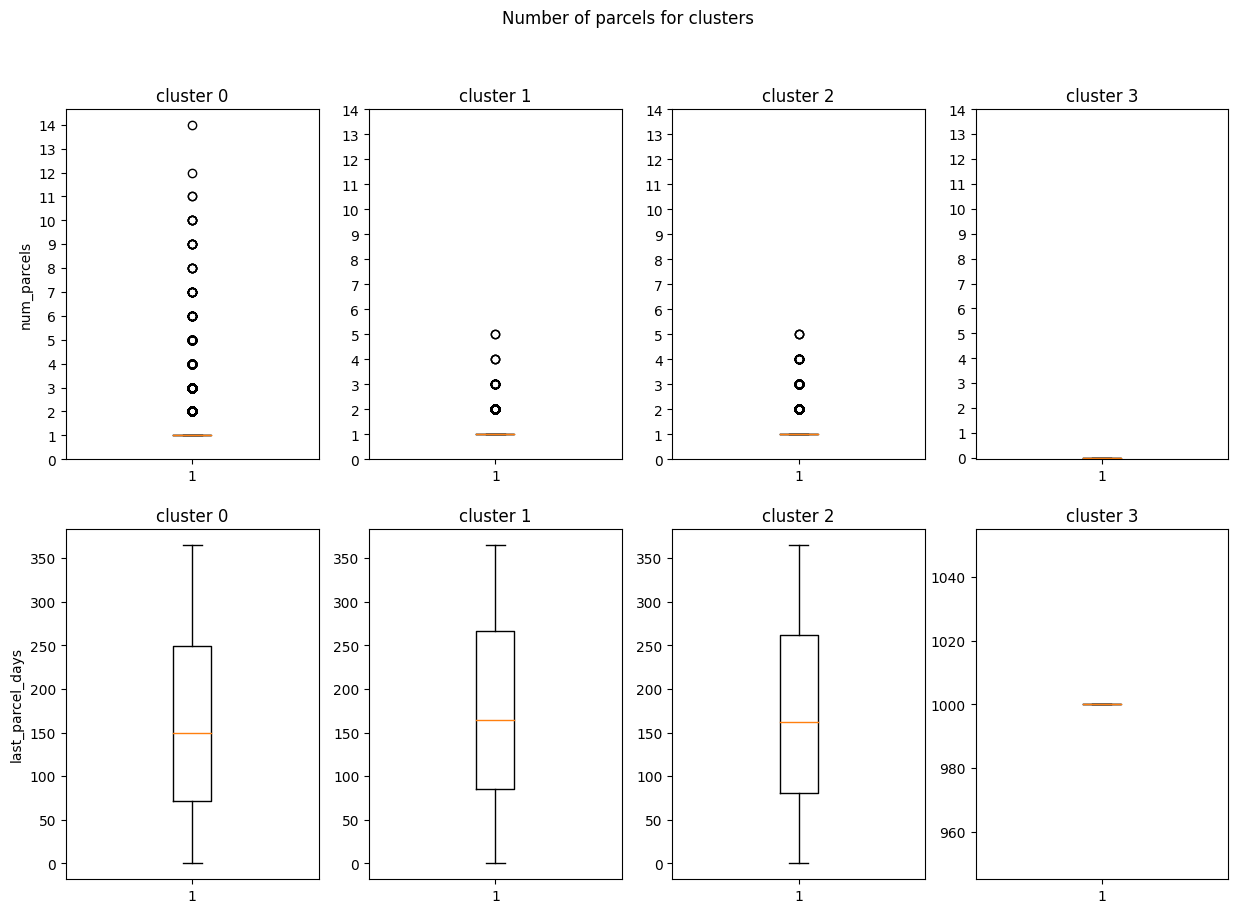

In [33]:
fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(15,10))
fig.suptitle('Number of parcels for clusters')
for j,var in enumerate(['num_parcels', 'last_parcel_days']):
    for cls in range(4):
        ax[j,cls].boxplot(res[res['cluster']==cls][var])
        ax[j,cls].set_title('cluster '+str(cls))
        if j == 0:
            ax[j, cls].set_yticks(range(15))
        if cls == 0:
            ax[j, cls].set_ylabel(var)

plt.show()



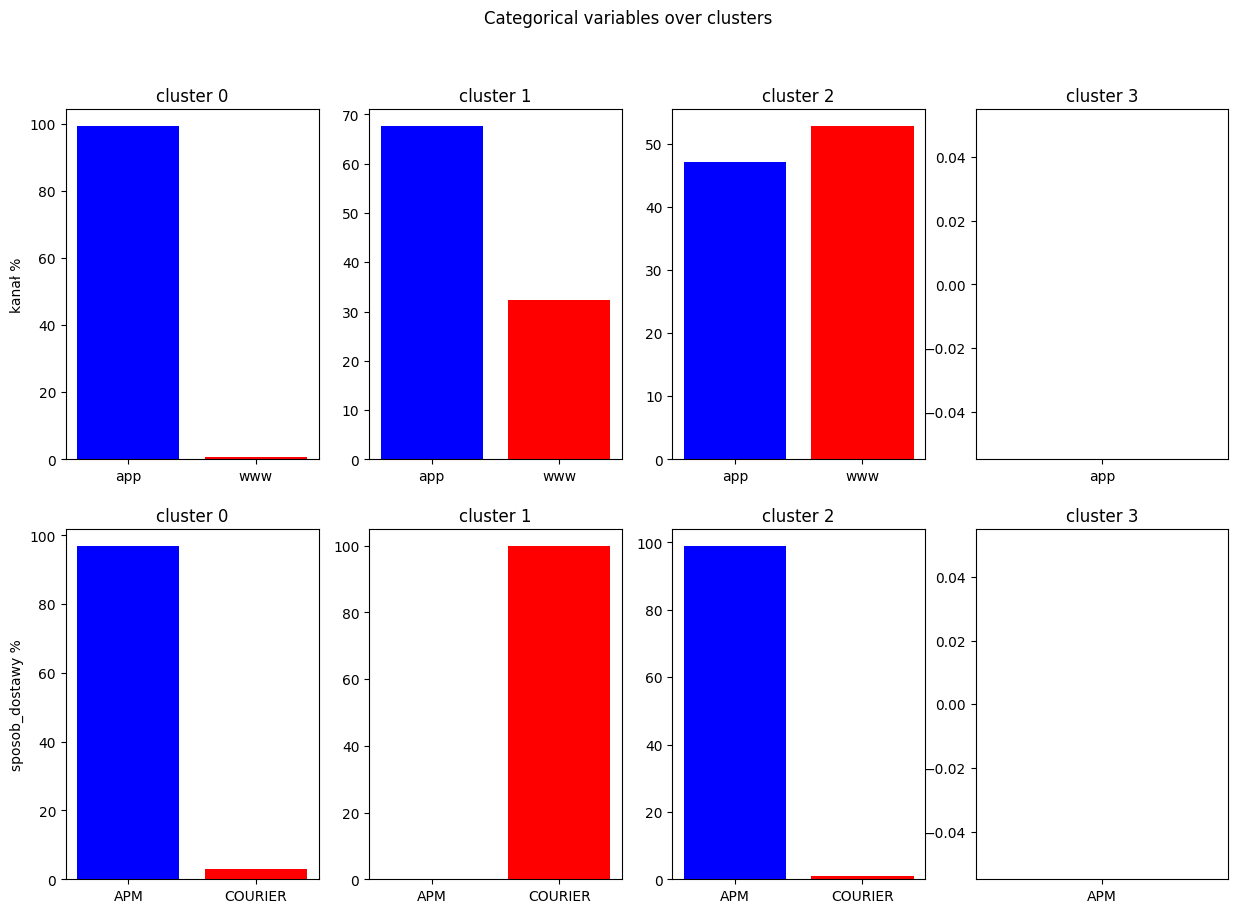

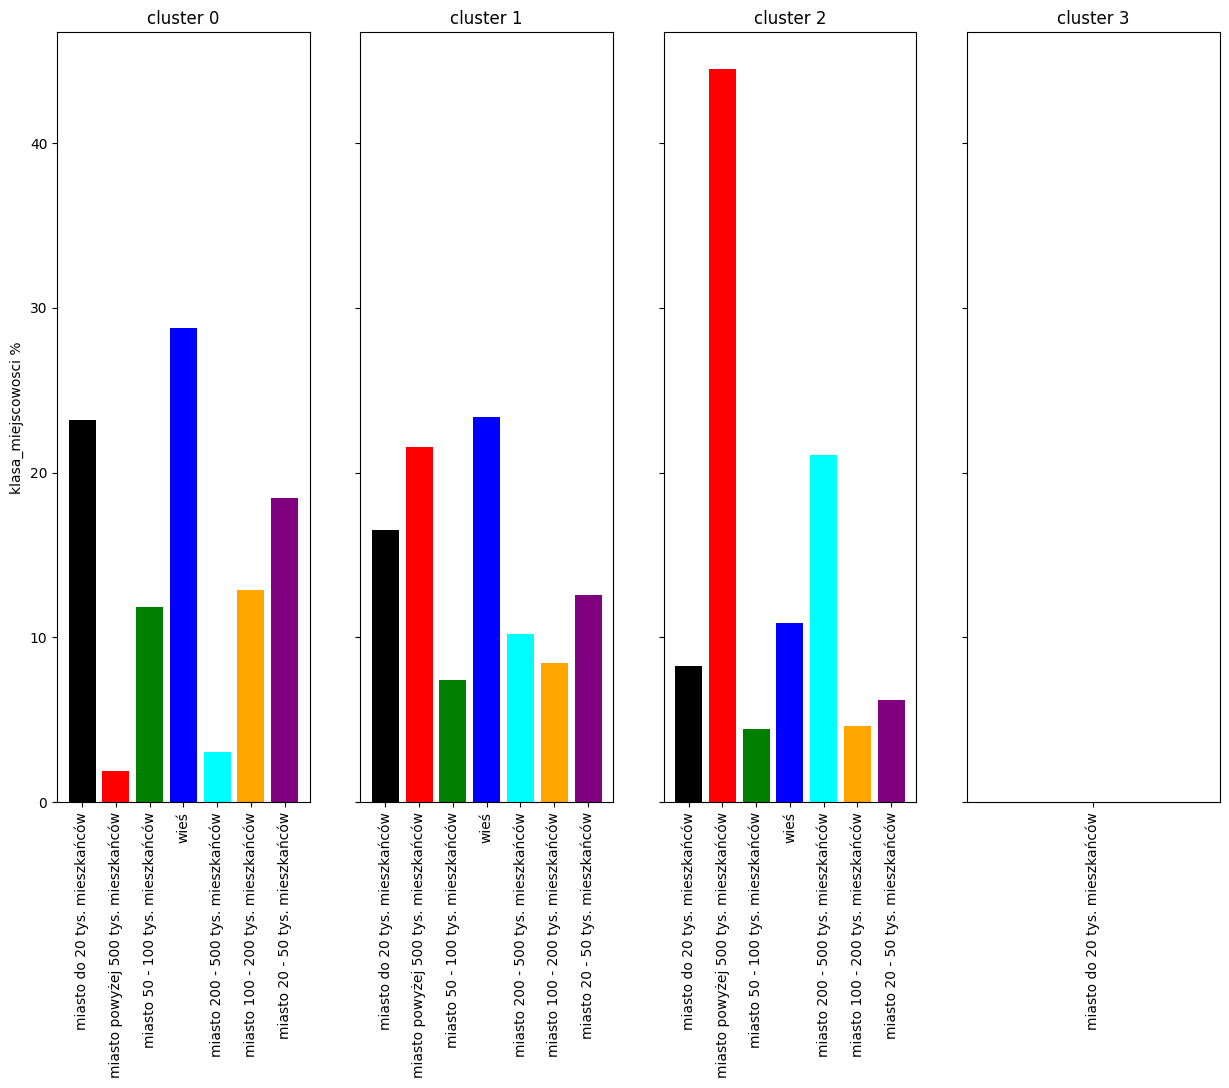

In [32]:

tmp = res.merge(parcels,how='inner', on=['id_klient'])
tmp.drop(columns=['klasa_miejscowosci'], inplace=True)

fig, ax = plt.subplots(nrows=2,ncols=4, figsize=(15,10))
fig.suptitle('Categorical variables over clusters')
for j, var in enumerate(['kanał','sposob_dostawy']):
    for cls in range(4):
        c_count = tmp[tmp['cluster']==cls][var].count()
        ax[j, cls].bar(tmp[var].unique()
                ,[100 * tmp[(tmp['cluster']==cls) & (tmp[var]==z)][var].count()/c_count for z in tmp[var].unique()]
                , color=['blue', 'red'])
        ax[j, cls].set_title('cluster '+str(cls))
        if cls == 0:
            ax[j, cls].set_ylabel(var + ' %')
plt.show()


tmp = tmp.merge(apms,how='inner', on=['id_paczkomat'])
var = 'klasa_miejscowosci'
fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(15,10), sharey=True)
for cls in range(4):
    c_count = tmp[tmp['cluster']==cls][var].count()
    ax[cls].bar(tmp[var].unique()
            ,[100 * tmp[(tmp['cluster']==cls) & (tmp[var]==z)][var].count()/c_count for z in tmp[var].unique()]
            ,color = ['black', 'red', 'green', 'blue', 'cyan', 'orange', 'purple'])
    ax[cls].set_title('cluster '+str(cls))
    ax[cls].tick_params(axis='x', labelrotation = 90)
    if cls == 0:
        ax[cls].set_ylabel(var + ' %')

plt.show()


Looking at the plots I give a brief description of each cluster:

**cluser 0  - frequent app to apm in smaller towns** - clients falling into this cluster are the most frequent senders, they grossly choose APM's over couriers  and the send parcels exclusively via the application. Also, a intreseting trait is that they mainy operate in villages and smaller towns. 

**cluser 1  - courier customers** - occasional customers that almost exclusively sent via courier delivery. They moderetaly prefer application vs website and the towns make up a  mixture of sizes.

**cluser 2  - APM customers in bigger towns** - occasional customers that mainly operate in cities and bigger towns that prefer APM over courier delivery. The usage of application vs website is about the same in this segment.

**cluser 3  - dormant clients** - these are clients that have not sent one parcel in the last 12 months. We can consider them as dormant clients.





In [47]:
#A = pd.concat([C, df['id_klient']] ,axis=1).merge(parcels,how='left', on=['id_klient']).merge(apms,how='left', on=['id_paczkomat']).merge(customers, how='left', on=['id_klient'])


In [53]:
2650*0.085

225.25000000000003

In [54]:
1600*0.085

136.0

In [57]:
1800*0.085

153.0

In [60]:
6*2650+1800*3+1600*2

24500

In [65]:
(6*2650+1800*3+1600*2)*0.085

2082.5

In [63]:
2650*0.085

225.25000000000003

In [66]:
21000*0.015


315.0